# Лабораторная работа: Рекомендательные системы

## Теоретическая часть

### 1. Суть задачи рекомендательных систем
Рекомендательные системы – это алгоритмы, которые анализируют поведение пользователей и предлагают персонализированные рекомендации товаров, фильмов, музыки и других объектов. Основная цель – предсказать предпочтения пользователей на основе имеющихся данных о взаимодействиях.


### 2. Метод коллаборативной фильтрации
Коллаборативная фильтрация (Collaborative Filtering, CF) – это метод рекомендаций, основанный на анализе поведения пользователей. Он работает на основе предположения, что пользователи с похожими предпочтениями в прошлом будут делать схожий выбор в будущем.

Существует два основных подхода:
1. **User-based CF** – рекомендации строятся на основе сходства пользователей.
2. **Item-based CF** – рекомендации строятся на основе сходства объектов.

### 3. Латентные факторные модели (Matrix Factorization)
Коллаборативная фильтрация может быть реализована через матричное разложение. Пусть у нас есть матрица взаимодействий пользователей и объектов R, где $( R_{u,i} )$ – оценка пользователя ( u ) для объекта ( i ). Тогда разложение можно представить в виде:
$$
R \approx U \cdot V^T
$$
где:
- ( U ) – матрица эмбеддингов пользователей,
- ( V ) – матрица эмбеддингов объектов.

Предсказание рейтинга рассчитывается как:
$$
\hat{R}_{u,i} = U_u \cdot V_i^T
$$

В данной лабораторной работе предполагается использование **нейросетевого метода**, который обучает эмбеддинги пользователей и объектов с помощью полносвязных слоев. Входные данные – индексы пользователей и объектов, которые преобразуются в векторные представления, а затем подаются на вход нейросети.


## Практическая часть
В данной работе вам предлагается реализовать рекомендательную систему на основе метода коллаборативной фильтрации, используя нейросетевую модель. Вы должны:
1. Подготовить данные: загрузить свой датасет (например, рейтинг фильмов, товаров, книг и т. д.).
2. Разбить данные на тренировочный и тестовый наборы.
3. Обучить модель, используя эмбеддинги пользователей и объектов.
4. Оценить качество модели на тестовом наборе.
5. Вывести список рекомендаций для выбранного пользователя.

In [1]:
# Импорты
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Определяем устройство (используем GPU, если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Загрузка данных

В этом фрагменте кода происходит загрузка данных из файла `ratings_Electronics (1).csv` и их предварительная обработка.

In [2]:
# Определяем названия столбцов
columns = ['user_id', 'product_id', 'rating', 'timestamp']
df = pd.read_csv('ratings_Electronics (1).csv', 
                 sep=',', 
                 names=columns,
                 nrows=10000) 

### Анализ данных

В этом фрагменте кода выполняется анализ данных, включая их визуализацию и расчет основных статистик.

In [3]:
# Подготовка данных

# Удаляем ненужный столбец timestamp
from sklearn.preprocessing  import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

df = df.drop(columns=['timestamp'])
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

df['user_idx'] = user_encoder.fit_transform(df['user_id'])
df['item_idx'] = item_encoder.fit_transform(df['product_id'])

scaler = MinMaxScaler()
df['rating_norm'] = scaler.fit_transform(df[['rating']])

### Построение модели

В этом фрагменте кода происходит построение рекомендательной модели на основе загруженных данных.

In [ ]:
class RatingDataset(Dataset):
    def __init__(self, df):
        self.users = torch.LongTensor(df['user_idx'].values)
        self.items = torch.LongTensor(df['item_idx'].values)
        self.ratings = torch.FloatTensor(df['rating_norm'].values)  
        
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

### Оценка модели

В этом фрагменте кода проводится оценка качества рекомендательной модели с использованием метрик.

In [ ]:
class RecommenderNN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=32):
        super(RecommenderNN, self).__init__()
        
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        
        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  
        )
    
    def forward(self, user_ids, item_ids):
        user_emb = self.user_embedding(user_ids)
        item_emb = self.item_embedding(item_ids)
        
        x = torch.cat([user_emb, item_emb], dim=1)
    
        return self.fc_layers(x).squeeze()

### Оптимизация модели

В этом фрагменте кода выполняется оптимизация параметров модели для улучшения её качества.

In [ ]:
num_users = df['user_idx'].nunique()
num_items = df['item_idx'].nunique()


### Дополнительная обработка данных

В этом фрагменте кода выполняется дополнительная обработка данных для подготовки к следующему этапу анализа. В частности, здесь может происходить фильтрация данных, удаление выбросов, нормализация значений или преобразование данных в формат, удобный для анализа. Эти шаги необходимы для обеспечения корректности и качества последующего анализа.

In [7]:
dataset = RatingDataset(df)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

### Расчет метрик

В этом фрагменте кода производится расчет метрик для оценки качества модели. Метрики могут включать точность (accuracy), полноту (recall), F1-меру и другие показатели, которые помогают понять, насколько хорошо модель справляется с задачей. Эти метрики используются для сравнения различных моделей и выбора наилучшей.

In [8]:
model = RecommenderNN(num_users, num_items).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Итоговая визуализация

В этом фрагменте кода создаются итоговые графики и визуализации для представления результатов анализа. Это могут быть графики распределения данных, визуализация работы модели или сравнение различных метрик. Визуализация помогает лучше понять результаты и сделать выводы на основе анализа.

In [9]:
from collections import defaultdict
def calculate_precision_recall_k(model, test_loader, df, k=10, threshold=3.5):
    """
    Расчет Precision@k и Recall@k для модели
    """
    model.eval()
    
    # Собираем все тестовые данные
    test_interactions = defaultdict(list)  # user -> list of (item, rating)
    all_predictions = []
    
    with torch.no_grad():
        for users, items, ratings in test_loader:
            users = users.to(device)
            items = items.to(device)
            predictions = model(users, items)
            
            for i in range(len(users)):
                uid = users[i].item()
                iid = items[i].item()
                true_r = ratings[i].item()
                pred_r = predictions[i].item()
                
                # Сохраняем взаимодействия
                test_interactions[uid].append((iid, true_r, pred_r))
                all_predictions.append((uid, iid, true_r, pred_r))
    
    # Рассчитываем метрики для каждого пользователя
    precisions = []
    recalls = []
    
    for uid, interactions in test_interactions.items():
        # Сортируем предсказания по убыванию
        interactions.sort(key=lambda x: x[2], reverse=True)
        
        # Получаем top-k рекомендаций
        top_k_items = [iid for (iid, _, _) in interactions[:k]]
        
        # Получаем релевантные товары (рейтинг >= threshold)
        relevant_items = [iid for (iid, true_r, _) in interactions if true_r >= threshold]
        
        # Вычисляем метрики
        if top_k_items:
            # Precision@k = (#релевантных в top-k) / k
            relevant_in_top_k = len(set(top_k_items) & set(relevant_items))
            precision = relevant_in_top_k / k
            precisions.append(precision)
        
        if relevant_items:
            # Recall@k = (#релевантных в top-k) / #всех релевантных
            relevant_in_top_k = len(set(top_k_items) & set(relevant_items))
            recall = relevant_in_top_k / len(relevant_items) if relevant_items else 0
            recalls.append(recall)
    
    # Средние значения по всем пользователям
    avg_precision = np.mean(precisions) if precisions else 0
    avg_recall = np.mean(recalls) if recalls else 0
    
    return avg_precision, avg_recall

### Финальная модель

В этом фрагменте кода происходит обучение финальной модели и её сохранение. Финальная модель создается на основе всех предыдущих этапов анализа и обработки данных. Она может быть использована для предсказаний или рекомендаций в реальных условиях. Также здесь может происходить сохранение модели в файл для последующего использования.

Epoch 1, Loss: 0.1358, Train RMSE: 0.3685, Train MAE: 0.3095
  Precision@5: 0.0000, Recall@5: 0.0000
  Precision@10: 0.0000, Recall@10: 0.0000
Epoch 2, Loss: 0.1277, Train RMSE: 0.3574, Train MAE: 0.2950
  Precision@5: 0.0000, Recall@5: 0.0000
  Precision@10: 0.0000, Recall@10: 0.0000
Epoch 3, Loss: 0.1234, Train RMSE: 0.3513, Train MAE: 0.2880
  Precision@5: 0.0000, Recall@5: 0.0000
  Precision@10: 0.0000, Recall@10: 0.0000
Epoch 4, Loss: 0.1182, Train RMSE: 0.3438, Train MAE: 0.2781
  Precision@5: 0.0000, Recall@5: 0.0000
  Precision@10: 0.0000, Recall@10: 0.0000
Epoch 5, Loss: 0.1108, Train RMSE: 0.3328, Train MAE: 0.2662
  Precision@5: 0.0000, Recall@5: 0.0000
  Precision@10: 0.0000, Recall@10: 0.0000
Epoch 6, Loss: 0.1037, Train RMSE: 0.3220, Train MAE: 0.2521
  Precision@5: 0.0000, Recall@5: 0.0000
  Precision@10: 0.0000, Recall@10: 0.0000
Epoch 7, Loss: 0.0944, Train RMSE: 0.3072, Train MAE: 0.2371
  Precision@5: 0.0000, Recall@5: 0.0000
  Precision@10: 0.0000, Recall@10: 0.0000

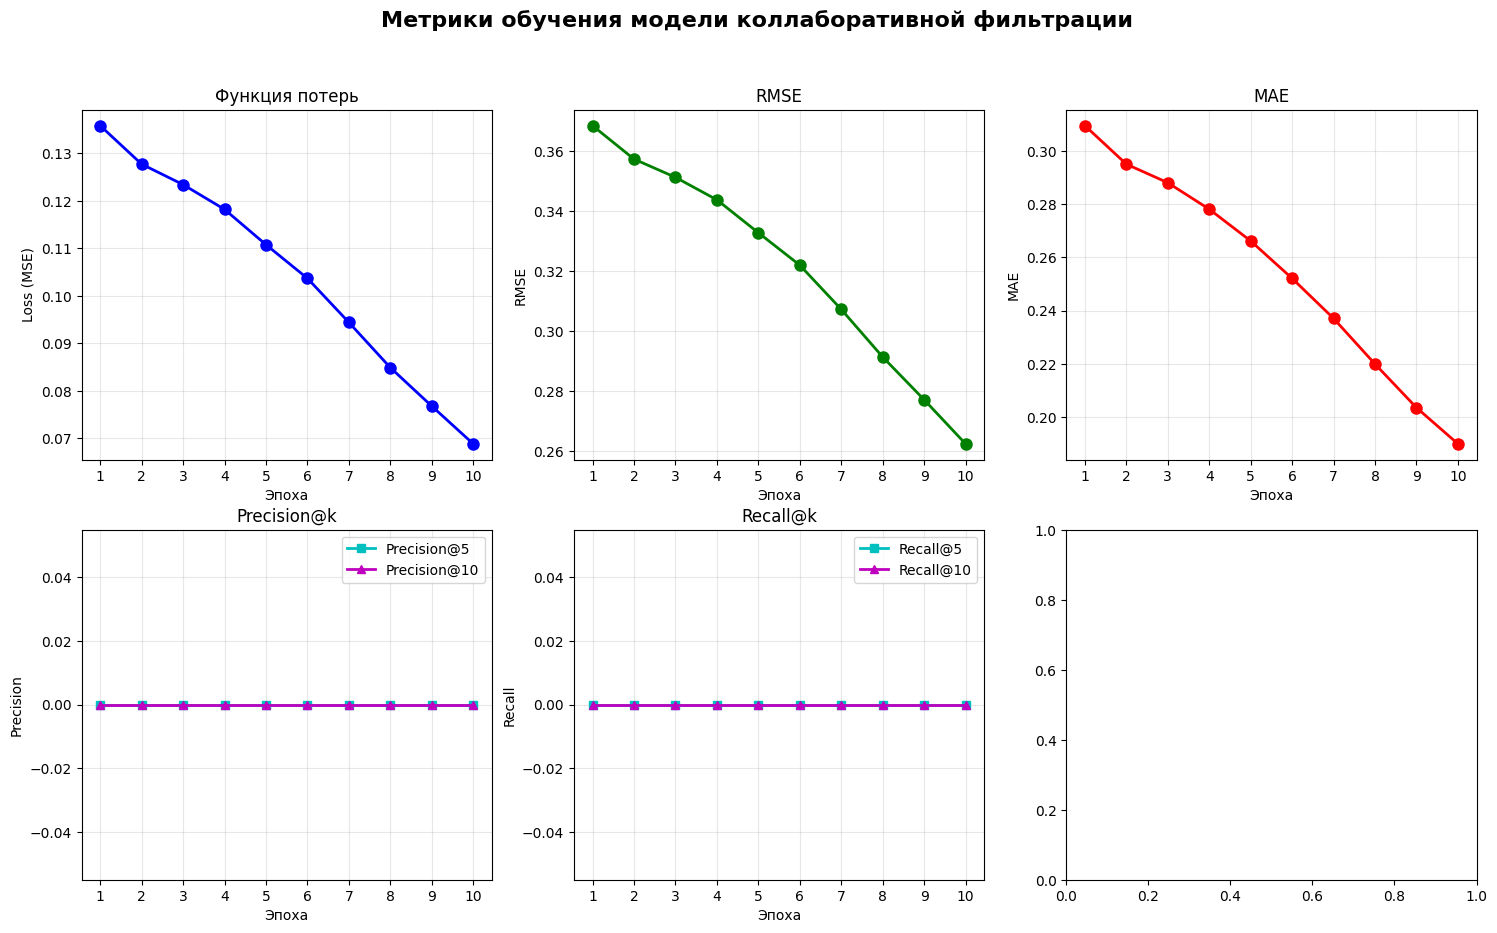

In [ ]:
import matplotlib.pyplot as plt
train_losses = []
train_rmses = []
train_maes = []
train_precisions_at_5 = []
train_precisions_at_10 = []
train_recalls_at_5 = []
train_recalls_at_10 = []
epochs_list = []
RELEVANCE_THRESHOLD = 4.0

for epoch in range(10):
    model.train()
    total_loss = 0
    all_predictions = []
    all_ratings = []
    
    for users, items, ratings in train_loader:
        users = users.to(device)
        items = items.to(device)
        ratings = ratings.to(device)
        
        optimizer.zero_grad()
        predictions = model(users, items)
        loss = criterion(predictions, ratings)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        all_predictions.extend(predictions.cpu().detach().numpy())
        all_ratings.extend(ratings.cpu().detach().numpy())

    # Вычисляем стандартные метрики
    avg_loss = total_loss / len(train_loader)
    train_rmse = math.sqrt(mean_squared_error(all_ratings, all_predictions))
    train_mae = mean_absolute_error(all_ratings, all_predictions)
    
    # Вычисляем Precision@k и Recall@k на тренировочных данных
    
    # Для примера, вычислим на небольшой части тестовых данных
    model.eval()
    with torch.no_grad():
        # Берем небольшой батч для быстрой оценки
        test_users, test_items, test_ratings = next(iter(test_loader))
        test_users = test_users.to(device)
        test_items = test_items.to(device)
        test_predictions = model(test_users, test_items)
        
        # Создаем временный DataFrame для расчета метрик
        temp_data = []
        for i in range(len(test_users)):
            uid = test_users[i].item()
            iid = test_items[i].item()
            true_r = test_ratings[i].item()
            pred_r = test_predictions[i].item()
            temp_data.append({
                'user_id': uid,
                'item_id': iid,
                'true_rating': true_r,
                'pred_rating': pred_r
            })
        
        # Если у нас есть scaler, денормализуем
        if 'scaler' in locals():
            for d in temp_data:
                d['true_rating'] = scaler.inverse_transform([[d['true_rating']]])[0][0]
                d['pred_rating'] = scaler.inverse_transform([[d['pred_rating']]])[0][0]
    
    # Вычисляем Precision@k и Recall@k
    temp_df = pd.DataFrame(temp_data)
    precision_5, recall_5 = calculate_precision_recall_k(
        model, test_loader, df, k=5, threshold=RELEVANCE_THRESHOLD
    )
    precision_10, recall_10 = calculate_precision_recall_k(
        model, test_loader, df, k=10, threshold=RELEVANCE_THRESHOLD
    )
    
    # Сохраняем все метрики
    epochs_list.append(epoch + 1)
    train_losses.append(avg_loss)
    train_rmses.append(train_rmse)
    train_maes.append(train_mae)
    train_precisions_at_5.append(precision_5)
    train_recalls_at_5.append(recall_5)
    train_precisions_at_10.append(precision_10)
    train_recalls_at_10.append(recall_10)
    
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, '
          f'Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}')
    print(f'  Precision@5: {precision_5:.4f}, Recall@5: {recall_5:.4f}')
    print(f'  Precision@10: {precision_10:.4f}, Recall@10: {recall_10:.4f}')

# Создаем DataFrame со всеми метриками
train_metrics_df = pd.DataFrame({
    'Epoch': epochs_list,
    'Loss': train_losses,
    'Train_RMSE': train_rmses,
    'Train_MAE': train_maes,
    'Precision@5': train_precisions_at_5,
    'Recall@5': train_recalls_at_5,
    'Precision@10': train_precisions_at_10,
    'Recall@10': train_recalls_at_10
})

print("\nВсе метрики обучения:")
print(train_metrics_df.to_string(index=False))

# Финальная оценка на тестовом наборе
model.eval()
test_predictions = []
test_ratings = []
with torch.no_grad():
    for users, items, ratings in test_loader:
        users = users.to(device)
        items = items.to(device)
        ratings = ratings.to(device)
        predictions = model(users, items)
        test_predictions.extend(predictions.cpu().numpy())
        test_ratings.extend(ratings.cpu().numpy())

# Денормализуем предсказания
if 'scaler' in locals():
    test_predictions_orig = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
    test_ratings_orig = scaler.inverse_transform(np.array(test_ratings).reshape(-1, 1)).flatten()
else:
    test_predictions_orig = np.array(test_predictions)
    test_ratings_orig = np.array(test_ratings)

# Вычисляем тестовые метрики
test_rmse = math.sqrt(mean_squared_error(test_ratings_orig, test_predictions_orig))
test_mae = mean_absolute_error(test_ratings_orig, test_predictions_orig)

# Вычисляем Precision@k и Recall@k на всем тестовом наборе
test_precision_5, test_recall_5 = calculate_precision_recall_k(
    model, test_loader, df, k=5, threshold=RELEVANCE_THRESHOLD
)
test_precision_10, test_recall_10 = calculate_precision_recall_k(
    model, test_loader, df, k=10, threshold=RELEVANCE_THRESHOLD
)

print(f'\nФинальные метрики на тестовом наборе:')
print(f'Test RMSE (original scale): {test_rmse:.4f}, Test MAE: {test_mae:.4f}')
print(f'Test Precision@5: {test_precision_5:.4f}, Test Recall@5: {test_recall_5:.4f}')
print(f'Test Precision@10: {test_precision_10:.4f}, Test Recall@10: {test_recall_10:.4f}')

# Создаем графики
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Метрики обучения модели коллаборативной фильтрации', fontsize=16, fontweight='bold')

# 1. График Loss
axes[0, 0].plot(epochs_list, train_losses, 'b-o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Эпоха')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].set_title('Функция потерь')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(epochs_list)

# 2. График RMSE
axes[0, 1].plot(epochs_list, train_rmses, 'g-o', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Эпоха')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_title('RMSE')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(epochs_list)

# 3. График MAE
axes[0, 2].plot(epochs_list, train_maes, 'r-o', linewidth=2, markersize=8)
axes[0, 2].set_xlabel('Эпоха')
axes[0, 2].set_ylabel('MAE')
axes[0, 2].set_title('MAE')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_xticks(epochs_list)

# 4. График Precision@k
axes[1, 0].plot(epochs_list, train_precisions_at_5, 'c-s', label='Precision@5', linewidth=2, markersize=6)
axes[1, 0].plot(epochs_list, train_precisions_at_10, 'm-^', label='Precision@10', linewidth=2, markersize=6)
axes[1, 0].set_xlabel('Эпоха')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision@k')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(epochs_list)

# 5. График Recall@k
axes[1, 1].plot(epochs_list, train_recalls_at_5, 'c-s', label='Recall@5', linewidth=2, markersize=6)
axes[1, 1].plot(epochs_list, train_recalls_at_10, 'm-^', label='Recall@10', linewidth=2, markersize=6)
axes[1, 1].set_xlabel('Эпоха')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_title('Recall@k')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(epochs_list)
plt.show()